<a href="https://colab.research.google.com/github/matteograsso98/energy_forecasting/blob/main/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy Forecaster - Neural Network Approach

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pwd
import pandas as pd
foto12 = pd.read_csv('/content/drive/MyDrive/foto12.csv')
corrid1 = pd.read_csv('/content/drive/MyDrive/corrid1.csv')
coper1 = pd.read_csv('/content/drive/MyDrive/coper1.csv')

/content


In [23]:
# Weather Data
foto12.keys()

Index(['Unnamed: 0', 'entity_type', 'created_at', 'dewPoint2mC',
       'diffuse_rad_1h_J', 'diffuseRadW', 'direct_rad_1h_J', 'directRadW',
       'global_rad_1h_J', 'hash_key', 'highCloudCoverP', 'lowCloudCoverP',
       'mediumCloudCoverP', 'mslPressureHpa', 'precipitation1hMm',
       'sfcPressureHpa', 'sort_key', 'up', 'windDirMean100m1hD',
       'windDirMean10m1hD', 'windGusts100m1hMs', 'windGusts100mMs',
       'windGusts10m1hMs', 'windGusts10mMs', 'windSpeedMean100m1hMs',
       'windSpeedMean10m1hMs', 'temperature2mC', 'ghi', 'dni', 'dhi', 'ghi-1',
       'dhi-1', 'dni-1', 'apparent_zenith', 'zenith', 'apparent_elevation',
       'elevation', 'azimuth', 'equation_of_time', 'ideal_azimuth',
       'max_radiation', 'overall_cloud_cover', 'previous_direct_rad',
       'previous_hour_rad', 'previous_diffuse_rad', 'previous_max_radiation',
       'next_direct_rad', 'next_diffuse_rad', 'next_max_radiation', 'sunrise',
       'dusk', 'day', 'cos_h', 'sin_h', 'cos_month', 'sin_month',

# Creating the Energy Forecaster
Here we create the neural network as part of a class called "Energy Forecaster".

---
The activation function is a parameterised sigmoid function

$ \sigma(z, \alpha, \beta) =  \beta + (1 - \beta) \cdot \frac{1}{1+e^{- \alpha z}}  $



In [29]:
import numpy as np
import tensorflow as tf

class EnergyForecasterNN:
    def __init__(self, input_features, n_hidden=[64, 64], seed=42):
        self.input_features = input_features
        self.input_dim = len(input_features)
        self.output_dim = 1  # Single value: energy production
        self.n_hidden = n_hidden
        self.seed = seed
        self._build_tf_model()

    def _custom_activation(self, x, alpha, beta):
        return (beta + (1 - beta) * tf.sigmoid(alpha * x)) * x

    def _build_tf_model(self):
        tf.random.set_seed(self.seed)
        inputs = tf.keras.Input(shape=(self.input_dim,), name="inputs")
        x = inputs

        self.alpha_params = []
        self.beta_params = []

        for i, hidden_size in enumerate(self.n_hidden):
            x = tf.keras.layers.Dense(hidden_size, name=f"dense_{i}")(x)

            # alpha and beta as trainable scalars
            alpha = tf.Variable(tf.random.uniform([1], 0.5, 1.5), name=f"alpha_{i}")
            beta = tf.Variable(tf.random.uniform([1], 0.1, 0.9), name=f"beta_{i}")
            self.alpha_params.append(alpha)
            self.beta_params.append(beta)

            # wrap into custom activation
            x = tf.keras.layers.Lambda(
                lambda x_, alpha=alpha, beta=beta: self._custom_activation(x_, alpha, beta),
                name=f"custom_activation_{i}"
            )(x)

        output = tf.keras.layers.Dense(1, name="output")(x)
        self.model = tf.keras.Model(inputs=inputs, outputs=output)
        self.model.compile(optimizer='adam', loss='mse', metrics = ['mae', 'mse'])

    def train(self, X, y, validation_split=0.2, epochs=300, batch_size=32, patience=30):
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=patience, restore_best_weights=True
        )
        history = self.model.fit(
            X, y,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=1
            # shuffle=True is implied here
        )
        return history

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X, y):
        return self.model.evaluate(X, y)

    def summary(self):
        self.model.summary()

# Data preparation and training/testing

We adopt the following metrics: MSE, MAE.

In [34]:
minimal_features = ['diffuseRadW', 'directRadW', 'temperature2mC', 'mediumCloudCoverP']
weather_data = foto12[minimal_features].to_numpy()
energy_data = foto12['kwh'].to_numpy()

In [25]:
weather_solar = pd.concat([foto12, corrid1, coper1], ignore_index=True)
minimal_features = ['diffuseRadW', 'directRadW', 'temperature2mC', 'mediumCloudCoverP']
weather_data = weather_solar[minimal_features].to_numpy()
energy_data = weather_solar['kwh'].to_numpy()

In [35]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#input_features: list of feature names (e.g., ["temperature", "radiation", ...])
#X should be a 2D NumPy array of shape (n_samples, len(input_features))
#y should be a 1D NumPy array of shape (n_samples,) with energy production in kWh

# Sample Data Preparation (Replace with your actual data)
# Assuming `weather_data` is a DataFrame with columns: 'temperature', 'diffuse_radiation', 'direct_radiation', etc.
# Assuming 'energy_data' is the target column for energy production (e.g., kWh)

# 1. Preprocessing: Normalize weather data and energy data
scaler_weather = MinMaxScaler()
scaler_energy = MinMaxScaler()

# Normalize weather data (input features)
weather_data_scaled = scaler_weather.fit_transform(weather_data)

# Normalize energy data (target variable)
energy_data_scaled = scaler_energy.fit_transform(energy_data.reshape(-1, 1))

# Split into train and test sets (80% train, 20% test)
split_idx = int(0.8 * len(weather_data))
X_train, X_test = weather_data_scaled[:split_idx], weather_data_scaled[split_idx:]
y_train, y_test = energy_data_scaled[:split_idx], energy_data_scaled[split_idx:]

model = EnergyForecasterNN(input_features=minimal_features)
model.summary()
model._build_tf_model()
history = model.train(X_train, y_train)
predictions = model.predict(X_test)

# Inverse transform predictions to get the actual energy production values
predictions_not_scaled = scaler_energy.inverse_transform(predictions)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_0 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_0 (Lambda)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_1 (Lambda)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0125 - mae: 0.0735 - mse: 0.0125 - val_loss: 0.0094 - val_mae: 0.0616 - val_mse: 0.0094
Epoch 2/300
862/862 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094 - mae: 0.0640 - mse: 0.0094 - val_loss: 0.0088 - val_mae: 0.0583 - val_mse: 0.0088
Epoch 3/300
862/862 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093 - mae: 0.0627 - mse: 0.0093 - val_loss: 0.0092 - val_mae: 0.0606 - val_mse: 0.0092
Epoch 4/300
862/862 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0091 - mae: 0.0617 - mse: 0.0091 - val_loss: 0.0094 - val_mae: 0.0613 - val_mse: 0.0094
Epoch 5/300
862/862 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0089 - mae: 0.0602 - mse: 0.0089 - val_loss: 0.0094 - val_mae: 0.0587 - val_mse: 0.0094
Epoch 6/300
862/862 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085 - mae: 0.0574 - mse: 0.0085 - val_loss: 0.0088 - val_mae: 0.0549 - val_mse: 0.0088
Epoch 7/300
862/862 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082 - mae: 0.0543 - mse: 0.008

In [38]:
# 5. Evaluate the model
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mae: 0.0476 - mse: 0.0069
Test Loss: 0.007446650415658951
Test MAE: 0.049193620681762695


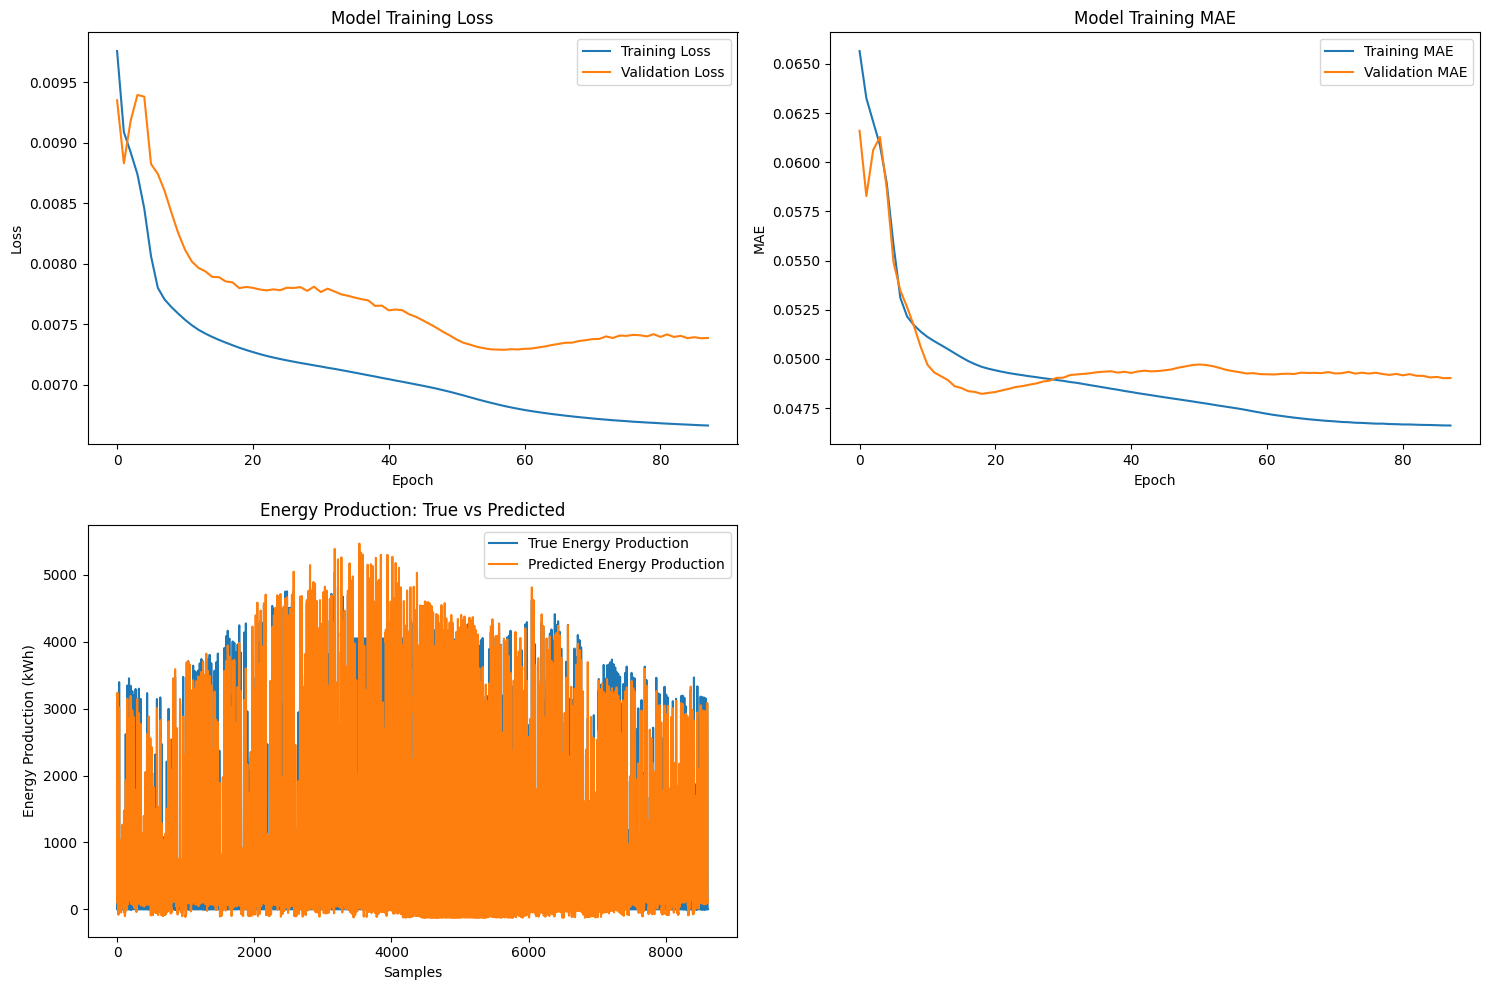

In [47]:
# Plot training & validation loss, MAE, and Predictions vs True Values as subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot training & validation loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot training & validation MAE
axes[0, 1].plot(history.history['mae'], label='Training MAE')
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE')
axes[0, 1].set_title('Model Training MAE')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()

# Visualizing Predictions vs True Values
axes[1, 0].plot(scaler_energy.inverse_transform(y_test.reshape(-1, 1)), label='True Energy Production')
axes[1, 0].plot(predictions_not_scaled, label='Predicted Energy Production')
axes[1, 0].set_title('Energy Production: True vs Predicted')
axes[1, 0].set_xlabel('Samples')
axes[1, 0].set_ylabel('Energy Production (kWh)')
axes[1, 0].legend()

#Remove the empty subplot
fig.delaxes(axes[1,1])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()